importing the dataset to notebook environment

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")

print("Path to dataset files:", path)

100%|██████████| 18.6M/18.6M [00:01<00:00, 10.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sunilthite/llm-detect-ai-generated-text-dataset/versions/1


In [3]:
path

'/root/.cache/kagglehub/datasets/sunilthite/llm-detect-ai-generated-text-dataset/versions/1'

In [4]:
import pandas as pd
text_df = pd.read_csv(filepath_or_buffer=path+"/Training_Essay_Data.csv")

In [5]:
text_df[text_df['generated']==0].sample(3)

,text,generated
3780,This is the age of technology everybody is con...,0
8108,I believe that the Facial Action Coding System...,0
18465,Most companies look for specific characteristi...,0


data checks

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

def char_length_summary(df, column=None, top_n=5, bins=50, figsize=(10,4)):
    """
    Strictly character length analysis for `column` in `df`.
    If column is None, picks a likely text column.
    """
    if column is None:
        candidates = ['text', 'essay', 'content', 'article', 'body']
        found = [c for c in candidates if c in df.columns]
        if found:
            column = found[0]
        else:
            obj_cols = [c for c, dt in df.dtypes.items() if dt == object]
            if not obj_cols:
                raise ValueError("No string columns found; pass `column` explicitly.")
            column = obj_cols[0]
    if column not in df.columns:
        raise ValueError(f"Column `{column}` not found in DataFrame.")

    s = df[column].fillna("").astype(str)
    char_len = s.str.len()

    stats = {
        'count': int(char_len.count()),
        'mean': float(char_len.mean()),
        'median': float(char_len.median()),
        'std': float(char_len.std()),
        'min': int(char_len.min()),
        'max': int(char_len.max()),
    }
    print("Character-length stats:", stats)

    pct = [1,5,25,50,75,95,99]
    q = char_len.quantile([p/100 for p in pct])
    print("\nPercentiles (characters):")
    for p, v in zip(pct, q.values):
        print(f"{p}%: {int(v)}")

    # Plot: single histogram (boxplot removed)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(char_len, bins=bins, ax=ax, kde=False)
    ax.set_title("Character length histogram")
    ax.set_xlabel("Characters")
    plt.tight_layout()
    plt.show()

    # Examples
    print(f"\nTop {top_n} shortest examples (by characters):")
    short_idx = char_len.nsmallest(top_n).index
    for i in short_idx:
        print(f"[{i}] len={char_len.loc[i]} -> {s.loc[i]!s}")

    print(f"\nTop {top_n} longest examples (by characters):")
    long_idx = char_len.nlargest(top_n).index
    for i in long_idx:
        print(f"[{i}] len={char_len.loc[i]} -> {s.loc[i]!s}")

Character-length stats: {'count': 29145, 'mean': 2235.996740435752, 'median': 2158.0, 'std': 987.346240017512, 'min': 1, 'max': 9157}

Percentiles (characters):
1%: 613
5%: 904
25%: 1505
50%: 2158
75%: 2750
95%: 4070
99%: 5237


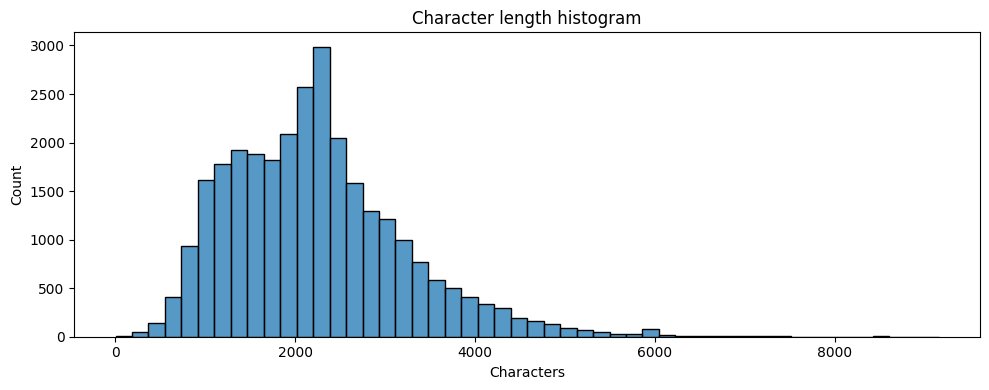


Top 5 shortest examples (by characters):
[2743] len=1 -> ]
[2744] len=24 -> ]
[Email]
[Phone Number]
[2735] len=26 -> ]

[Email]

[Phone Number]
[2753] len=32 -> ]
[Email Address]
[Phone Number]
[2825] len=32 -> ]
[Email Address]
[Phone Number]

Top 5 longest examples (by characters):
[3373] len=9157 -> Phones & driving

I strongly agree with cell phones being banned while driving. I can honestly say that I have almost run into someone's back on numerous occasions because I was focused on texting on my phone. I think driving while using cell phones should be banned because of the many car accidents they are causing, it is causing one's insurance to rise, and it is causing concern to people's health issues. The question is people more concerned more with their conveniences more than they are with their safety or safety of others. It is a habit that spreads like STDs. In the long run, it is deadly as well Cell phones are the omnipresent electronic device of this era, and multitasking is

In [7]:
char_length_summary(text_df, column='text')

## we will be training two models:
1. for whole essay classification
2. individual sentences classification

# <span style='color:green;'>whole essay classification model</span>

## <span style="color:#E5BAEE;">1. Data Cleaning</span>

1.1 text  normalization:
1. Lowercasing
2. unicode text normalization
3. removal of weird symbols

In [8]:
import re
import unicodedata
def clean_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text)
    # Remove URLs if any
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove HTML tags if any
    text = re.sub(r"<.*?>", "", text)

    # Remove extra whitespace but not inbetween words
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [9]:
text_df['clean_text'] = text_df['text'].apply(clean_text)

In [10]:
text_df

,text,generated,clean_text
0,Car-free cities have become a subject of incre...,1,car-free cities have become a subject of incre...
1,"Car Free Cities Car-free cities, a concept ga...",1,"car free cities car-free cities, a concept gai..."
2,A Sustainable Urban Future Car-free cities ...,1,a sustainable urban future car-free cities are...
3,Pioneering Sustainable Urban Living In an e...,1,pioneering sustainable urban living in an era ...
4,The Path to Sustainable Urban Living In an ...,1,the path to sustainable urban living in an age...
...,...,...,...
29140,There has been a fuss about the Elector Colleg...,0,there has been a fuss about the elector colleg...
29141,Limiting car usage has many advantages. Such a...,0,limiting car usage has many advantages. such a...
29142,There's a new trend that has been developing f...,0,there's a new trend that has been developing f...
29143,As we all know cars are a big part of our soci...,0,as we all know cars are a big part of our soci...


### ℹ️ important: punctuation is retained as it can be a proxy for writing style

## <span style="color:#E5BAEE;">2. Feature Engineering</span>
To classify AI vs human essays, the model must learn:

wording patterns

sentence structure patterns

transitions

vocabulary richness

repetitive phrasing

paragraph coherence

2.1 TF-IDF N-grams

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    lowercase=False,
    ngram_range=(1,3),
    min_df=5,
    max_df=0.9,
    max_features=50_000
)
X = vectorizer.fit_transform(text_df['clean_text'])
y = text_df['generated']

## 2.2 Stylometric Features (Boosts Accuracy)

AI text has predictable stylometric characteristics.

Addition of features like:

avg sentence length

paragraph count

punctuation count

lexical diversity

ratio of stopwords

uppercase/lowercase usage

average word length

In [12]:
# python
import spacy
from spacy.cli import download
import sys

try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    # Attempt to download the model into the current environment and load again
    print("Model 'en_core_web_sm' not found — downloading now...")
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# now safe to use nlp(...)

In [14]:
import numpy as np
import spacy
from tqdm.auto import tqdm

# Ultra-fast pipeline: tokenizer + sentencizer
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

def extract_style_features_bulk(texts, batch_size=64):
    features = []

    # Wrap nlp.pipe() with tqdm
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts), desc="Extracting features"):
        sentences = list(doc.sents)
        words = [token.text for token in doc if token.is_alpha]

        avg_sentence_len = np.mean([len(sent.text.split()) for sent in sentences]) if sentences else 0.0
        avg_word_len = np.mean([len(w) for w in words]) if words else 0.0
        lexical_diversity = len(set(words)) / (len(words) + 1e-6) if words else 0.0

        features.append([
            avg_sentence_len,
            avg_word_len,
            lexical_diversity,
            len(sentences)
        ])

    return np.array(features)

# Run the feature extractor with progress bar
texts = text_df["clean_text"].tolist()
style_features = extract_style_features_bulk(texts, batch_size=64)

Extracting features:   0%|          | 0/29145 [00:00<?, ?it/s]

In [15]:
from scipy.sparse import hstack

X_final = hstack([X, style_features])

In [16]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
model_pp = GPT2LMHeadModel.from_pretrained("distilgpt2").to(device)
torch.set_grad_enabled(False)

def perplexity(text):
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        add_special_tokens=False
    ).to(device)

    loss = model_pp(**enc, labels=enc["input_ids"]).loss
    return torch.exp(loss).item()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [17]:
text_df['perplexity'] = text_df['clean_text'].progress_apply(perplexity)

  0%|          | 0/29145 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [18]:
X_perplex = np.array(text_df['perplexity']).reshape(-1,1)
X_final = hstack([X, style_features, X_perplex])

In [19]:
text_df

,text,generated,clean_text,perplexity
0,Car-free cities have become a subject of incre...,1,car-free cities have become a subject of incre...,18.688168
1,"Car Free Cities Car-free cities, a concept ga...",1,"car free cities car-free cities, a concept gai...",20.730879
2,A Sustainable Urban Future Car-free cities ...,1,a sustainable urban future car-free cities are...,22.744978
3,Pioneering Sustainable Urban Living In an e...,1,pioneering sustainable urban living in an era ...,22.481089
4,The Path to Sustainable Urban Living In an ...,1,the path to sustainable urban living in an age...,23.722338
...,...,...,...,...
29140,There has been a fuss about the Elector Colleg...,0,there has been a fuss about the elector colleg...,47.147469
29141,Limiting car usage has many advantages. Such a...,0,limiting car usage has many advantages. such a...,33.490295
29142,There's a new trend that has been developing f...,0,there's a new trend that has been developing f...,55.108032
29143,As we all know cars are a big part of our soci...,0,as we all know cars are a big part of our soci...,67.453415


In [22]:
style_features

array([[20.53571429,  5.70686767,  0.45058626, 28.        ],
       [19.73076923,  5.89285714,  0.5018797 , 26.        ],
       [18.96296296,  6.04143126,  0.48022599, 27.        ],
       ...,
       [20.80555556,  4.6802168 ,  0.46747967, 36.        ],
       [16.93548387,  4.20348837,  0.45155039, 31.        ],
       [17.30769231,  4.89342404,  0.45578231, 26.        ]])

In [24]:
X_final

<COOrdinate sparse matrix of dtype 'float64'
	with 12744621 stored elements and shape (29145, 50005)>

In [26]:
y

,generated
0,1
1,1
2,1
3,1
4,1
...,...
29140,0
29141,0
29142,0
29143,0


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (23316, 50005)
Shape of X_test: (5829, 50005)
Shape of y_train: (23316,)
Shape of y_test: (5829,)


In [27]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=42)
model.fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearSVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values